In [20]:
from tools.utils import *
from tools.het_networks import *

import torch

from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader

from sklearn.model_selection import train_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [21]:
# Random
seed = 42

# Model
hidden_channels = 128
num_classes = 6
num_layers = 2
intra_aggr='mean'
inter_aggr='sum'
dropout = 0.5

# Training
batch_size = 32
epochs = 30
lr = 1e-4
maxlr = 3e-4

# Preprocessing

In [22]:
# Load the ENZYMES dataset
hom_dataset = TUDataset(root='data', name='ENZYMES')                          # This has 3 one-hot encodings
hom_dataset_attr = TUDataset(root='data', name='ENZYMES', use_node_attr=True) # This has 3 one-hot encodings and 18 features

In [23]:
def normalize_enzymes_data(data):
    data = data.clone()
    if hasattr(data, 'x') and data.x is not None:
        x = data.x
        feats = x[:, :18]
        mean = feats.mean(dim=0)
        std = feats.std(dim=0, unbiased=False)
        std[std == 0] = 1.0
        normalized_feats = (feats - mean) / std
        x[:, :18] = normalized_feats
        data.x = x
    return data

# Normalize features
normalized_hom_dataset_attr = [normalize_enzymes_data(hom_data) for hom_data in hom_dataset_attr]

In [24]:
# Construct het dataset
het_dataset = []
for hom_data in normalized_hom_dataset_attr:
    het_data = convert_hom_to_het(hom_data, onehot_indices=[18, 19, 20], is_directed=False)
    het_dataset.append(het_data)
het_dataset.__len__()

600

In [25]:
# Get the metadata to build HeteroGNN
edge_types = het_dataset[0].edge_types
node_types = het_dataset[0].node_types
metadata = (node_types, edge_types)
metadata

(['A', 'B', 'C'],
 [('A', 'edge_index', 'A'),
  ('A', 'edge_index', 'B'),
  ('A', 'edge_index', 'C'),
  ('B', 'edge_index', 'B'),
  ('B', 'edge_index', 'C'),
  ('C', 'edge_index', 'C')])

In [26]:
# Create splits
labels = [data.y.item() for data in het_dataset]

train_set, temp_set = train_test_split(
    het_dataset, 
    test_size=0.3, 
    stratify=labels,
    random_state=seed
    
)

temp_labels = [data.y.item() for data in temp_set]
valid_set, test_set = train_test_split(
    temp_set, 
    test_size=0.5, 
    stratify=temp_labels,
    random_state=seed
)

# train_loader is defined at each experiment for reproducibility
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# HeteroGNN_GraphConv

In [27]:
experiment_name = f"ENZYMES-HeteroGNN_GraphConv-{hidden_channels} hidden channels-{num_layers} mlp-{num_layers} conv-{intra_aggr} intra_aggr-{inter_aggr} inter_aggr-{dropout} dropout-{lr} lr-{maxlr} maxlr-OneCylceLR-Adam-CE Loss"

reset_seeds(seed, device)
train_loader = get_train_loader(seed, train_set, batch_size)
model = HeteroGNN_GraphConv(metadata, hidden_channels, num_classes, mlp_layers=num_layers, conv_layers=num_layers, intra_aggr=intra_aggr, inter_aggr=inter_aggr, dropout=dropout).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()
model

HeteroGNN_GraphConv(
  (node_emb_layers): ModuleDict(
    (A): MLP(
      (layers): ModuleList(
        (0): Linear(-1, 128, bias=True)
        (1): Dropout(p=0.5, inplace=False)
        (2): Linear(128, 128, bias=True)
      )
    )
    (B): MLP(
      (layers): ModuleList(
        (0): Linear(-1, 128, bias=True)
        (1): Dropout(p=0.5, inplace=False)
        (2): Linear(128, 128, bias=True)
      )
    )
    (C): MLP(
      (layers): ModuleList(
        (0): Linear(-1, 128, bias=True)
        (1): Dropout(p=0.5, inplace=False)
        (2): Linear(128, 128, bias=True)
      )
    )
  )
  (conv_blocks): ModuleList(
    (0-1): 2 x ModuleDict(
      (conv): HeteroConv(num_relations=6)
      (post_lin): ModuleDict(
        (A): MLP(
          (layers): ModuleList(
            (0): Linear(-1, 128, bias=True)
            (1): Dropout(p=0.5, inplace=False)
            (2): Linear(128, 128, bias=True)
          )
        )
        (B): MLP(
          (layers): ModuleList(
            (0):

In [28]:
batches_per_epoch = len(train_loader)
total_steps = epochs * batches_per_epoch

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=maxlr, total_steps=total_steps, epochs=epochs, cycle_momentum=False)

In [29]:
metrics = {
    'train_loss': [],
    'valid_loss': [],
    'train_acc': [],
    'valid_acc': [],
    'train_f1': [],
    'valid_f1': []
}

for epoch in range(1, epochs+1):
    train_loss, train_acc, train_f1 = train(model, train_loader, optimizer, criterion, het_predict, scheduler=scheduler, device=device)
    valid_loss, valid_acc, valid_f1 = test(model, valid_loader, criterion, het_predict, device=device)
    
    # Update metrics
    metrics['train_loss'].append(train_loss)
    metrics['valid_loss'].append(valid_loss)
    metrics['train_acc'].append(train_acc)
    metrics['valid_acc'].append(valid_acc)
    metrics['train_f1'].append(train_f1)
    metrics['valid_f1'].append(valid_f1)
    
    print(f"Epoch {epoch}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f} | Validation Acc: {valid_acc:.4f}")
    print(f"Train F1: {train_f1:.4f} | Validation F1: {valid_f1:.4f}\n")

Epoch 1/30
Train Loss: 1.7928 | Validation Loss: 1.7924
Train Acc: 0.1333 | Validation Acc: 0.1667
Train F1: 0.0745 | Validation F1: 0.0481

Epoch 2/30
Train Loss: 1.7922 | Validation Loss: 1.7923
Train Acc: 0.1738 | Validation Acc: 0.1667
Train F1: 0.1055 | Validation F1: 0.0476

Epoch 3/30
Train Loss: 1.7923 | Validation Loss: 1.7921
Train Acc: 0.1833 | Validation Acc: 0.1667
Train F1: 0.1081 | Validation F1: 0.0490

Epoch 4/30
Train Loss: 1.7915 | Validation Loss: 1.7916
Train Acc: 0.1786 | Validation Acc: 0.1667
Train F1: 0.1108 | Validation F1: 0.0476

Epoch 5/30
Train Loss: 1.7911 | Validation Loss: 1.7907
Train Acc: 0.1690 | Validation Acc: 0.1667
Train F1: 0.0813 | Validation F1: 0.0476

Epoch 6/30
Train Loss: 1.7876 | Validation Loss: 1.7884
Train Acc: 0.1810 | Validation Acc: 0.2000
Train F1: 0.1175 | Validation F1: 0.1085

Epoch 7/30
Train Loss: 1.7812 | Validation Loss: 1.7788
Train Acc: 0.1762 | Validation Acc: 0.1444
Train F1: 0.1121 | Validation F1: 0.0563

Epoch 8/30
Tr

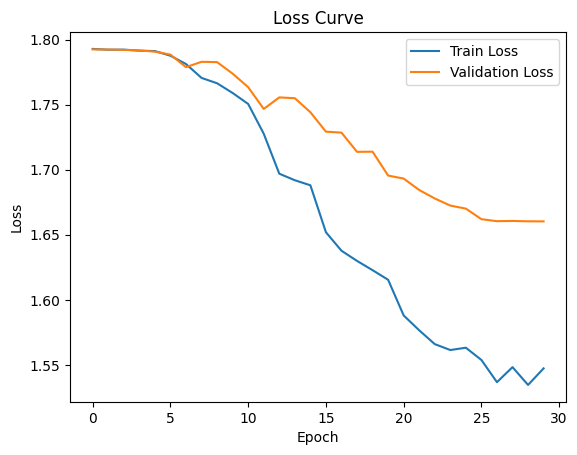

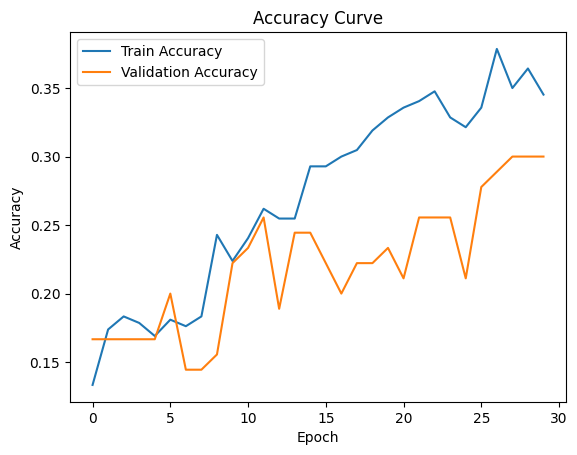

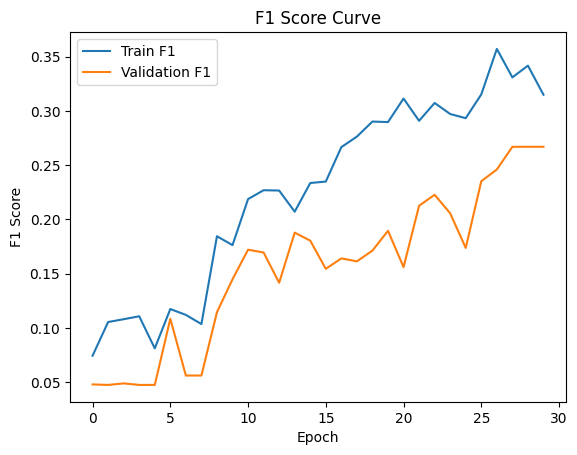

,Epoch,Train Loss,Valid Loss,Train Acc,Valid Acc,Train F1,Valid F1
0,1,1.7928,1.7924,0.1333,0.1667,0.0745,0.0481
1,2,1.7922,1.7923,0.1738,0.1667,0.1055,0.0476
2,3,1.7923,1.7921,0.1833,0.1667,0.1081,0.0490
3,4,1.7915,1.7916,0.1786,0.1667,0.1108,0.0476
4,5,1.7911,1.7907,0.1690,0.1667,0.0813,0.0476
5,6,1.7876,1.7884,0.1810,0.2000,0.1175,0.1085
6,7,1.7812,1.7788,0.1762,0.1444,0.1121,0.0563
7,8,1.7705,1.7829,0.1833,0.1444,0.1037,0.0563
8,9,1.7664,1.7827,0.2429,0.1556,0.1845,0.1146
9,10,1.7589,1.7738,0.2238,0.2222,0.1763,0.1449


In [30]:
plot_metrics(metrics, experiment_name)
create_metrics_table(metrics, experiment_name)

# HeteroGNN_SAGEConv

In [31]:
experiment_name = f"ENZYMES-HeteroGNN_SAGEConv-{hidden_channels} hidden channels-{num_layers} mlp-{num_layers} conv-{intra_aggr} intra_aggr-{inter_aggr} inter_aggr-{dropout} dropout-{lr} lr-{maxlr} maxlr-OneCylceLR-Adam-CE Loss"

reset_seeds(seed, device)
train_loader = get_train_loader(seed, train_set, batch_size)
model = HeteroGNN_SAGEConv(metadata, hidden_channels, num_classes, mlp_layers=num_layers, conv_layers=num_layers, intra_aggr=intra_aggr, inter_aggr=inter_aggr, dropout=dropout).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()
model

HeteroGNN_SAGEConv(
  (node_emb_layers): ModuleDict(
    (A): MLP(
      (layers): ModuleList(
        (0): Linear(-1, 128, bias=True)
        (1): Dropout(p=0.5, inplace=False)
        (2): Linear(128, 128, bias=True)
      )
    )
    (B): MLP(
      (layers): ModuleList(
        (0): Linear(-1, 128, bias=True)
        (1): Dropout(p=0.5, inplace=False)
        (2): Linear(128, 128, bias=True)
      )
    )
    (C): MLP(
      (layers): ModuleList(
        (0): Linear(-1, 128, bias=True)
        (1): Dropout(p=0.5, inplace=False)
        (2): Linear(128, 128, bias=True)
      )
    )
  )
  (conv_blocks): ModuleList(
    (0-1): 2 x ModuleDict(
      (conv): HeteroConv(num_relations=6)
      (post_lin): ModuleDict(
        (A): MLP(
          (layers): ModuleList(
            (0): Linear(-1, 128, bias=True)
            (1): Dropout(p=0.5, inplace=False)
            (2): Linear(128, 128, bias=True)
          )
        )
        (B): MLP(
          (layers): ModuleList(
            (0): 

In [32]:
batches_per_epoch = len(train_loader)
total_steps = epochs * batches_per_epoch

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=maxlr, total_steps=total_steps, epochs=epochs, cycle_momentum=False)

In [33]:
metrics = {
    'train_loss': [],
    'valid_loss': [],
    'train_acc': [],
    'valid_acc': [],
    'train_f1': [],
    'valid_f1': []
}

for epoch in range(1, epochs+1):
    train_loss, train_acc, train_f1 = train(model, train_loader, optimizer, criterion, het_predict, scheduler=scheduler, device=device)
    valid_loss, valid_acc, valid_f1 = test(model, valid_loader, criterion, het_predict, device=device)
    
    # Update metrics
    metrics['train_loss'].append(train_loss)
    metrics['valid_loss'].append(valid_loss)
    metrics['train_acc'].append(train_acc)
    metrics['valid_acc'].append(valid_acc)
    metrics['train_f1'].append(train_f1)
    metrics['valid_f1'].append(valid_f1)
    
    print(f"Epoch {epoch}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f} | Validation Acc: {valid_acc:.4f}")
    print(f"Train F1: {train_f1:.4f} | Validation F1: {valid_f1:.4f}\n")

Epoch 1/30
Train Loss: 1.7928 | Validation Loss: 1.7924
Train Acc: 0.1333 | Validation Acc: 0.1667
Train F1: 0.0745 | Validation F1: 0.0481

Epoch 2/30
Train Loss: 1.7922 | Validation Loss: 1.7923
Train Acc: 0.1738 | Validation Acc: 0.1667
Train F1: 0.1055 | Validation F1: 0.0476

Epoch 3/30
Train Loss: 1.7923 | Validation Loss: 1.7921
Train Acc: 0.1833 | Validation Acc: 0.1667
Train F1: 0.1081 | Validation F1: 0.0490

Epoch 4/30
Train Loss: 1.7915 | Validation Loss: 1.7916
Train Acc: 0.1786 | Validation Acc: 0.1667
Train F1: 0.1108 | Validation F1: 0.0476

Epoch 5/30
Train Loss: 1.7911 | Validation Loss: 1.7907
Train Acc: 0.1690 | Validation Acc: 0.1667
Train F1: 0.0813 | Validation F1: 0.0476

Epoch 6/30
Train Loss: 1.7876 | Validation Loss: 1.7884
Train Acc: 0.1810 | Validation Acc: 0.2000
Train F1: 0.1175 | Validation F1: 0.1085

Epoch 7/30
Train Loss: 1.7812 | Validation Loss: 1.7788
Train Acc: 0.1762 | Validation Acc: 0.1444
Train F1: 0.1121 | Validation F1: 0.0563

Epoch 8/30
Tr

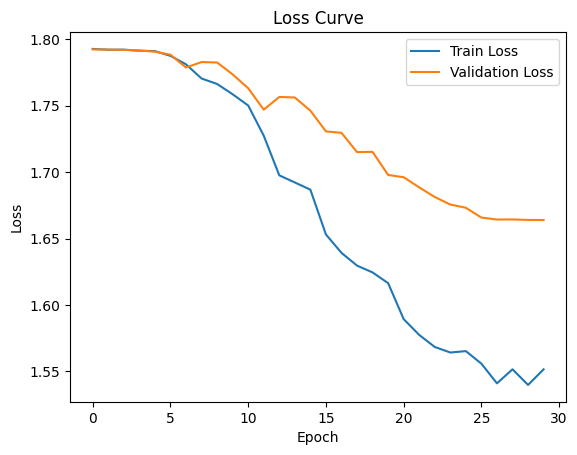

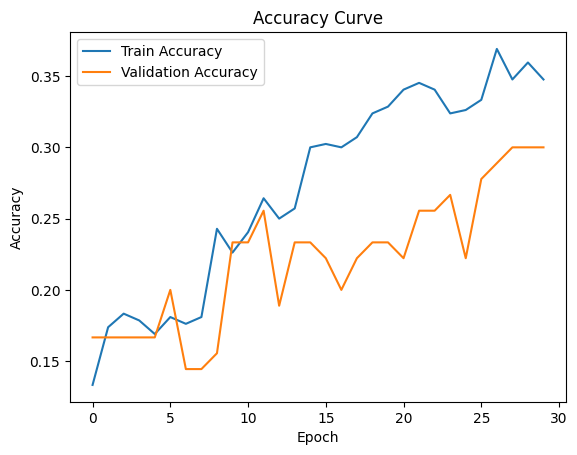

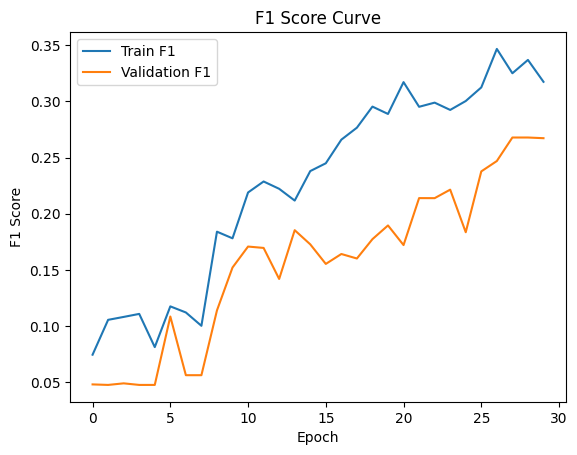

,Epoch,Train Loss,Valid Loss,Train Acc,Valid Acc,Train F1,Valid F1
0,1,1.7928,1.7924,0.1333,0.1667,0.0745,0.0481
1,2,1.7922,1.7923,0.1738,0.1667,0.1055,0.0476
2,3,1.7923,1.7921,0.1833,0.1667,0.1081,0.0490
3,4,1.7915,1.7916,0.1786,0.1667,0.1108,0.0476
4,5,1.7911,1.7907,0.1690,0.1667,0.0813,0.0476
5,6,1.7876,1.7884,0.1810,0.2000,0.1175,0.1085
6,7,1.7812,1.7788,0.1762,0.1444,0.1121,0.0563
7,8,1.7705,1.7829,0.1810,0.1444,0.1002,0.0563
8,9,1.7664,1.7826,0.2429,0.1556,0.1840,0.1139
9,10,1.7586,1.7736,0.2262,0.2333,0.1781,0.1521


In [34]:
plot_metrics(metrics, experiment_name)
create_metrics_table(metrics, experiment_name)

# HeteroGNN_GATConv

In [35]:
experiment_name = f"ENZYMES-HeteroGNN_GATConv-{hidden_channels} hidden channels-{num_layers} mlp-{num_layers} conv-{intra_aggr} intra_aggr-{inter_aggr} inter_aggr-{dropout} dropout-{lr} lr-{maxlr} maxlr-OneCylceLR-Adam-CE Loss"

reset_seeds(seed, device)
train_loader = get_train_loader(seed, train_set, batch_size)
model = HeteroGNN_GATConv(metadata, hidden_channels, num_classes, mlp_layers=num_layers, conv_layers=num_layers, intra_aggr=intra_aggr, inter_aggr=inter_aggr, dropout=dropout).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()
model

HeteroGNN_GATConv(
  (node_emb_layers): ModuleDict(
    (A): MLP(
      (layers): ModuleList(
        (0): Linear(-1, 128, bias=True)
        (1): Dropout(p=0.5, inplace=False)
        (2): Linear(128, 128, bias=True)
      )
    )
    (B): MLP(
      (layers): ModuleList(
        (0): Linear(-1, 128, bias=True)
        (1): Dropout(p=0.5, inplace=False)
        (2): Linear(128, 128, bias=True)
      )
    )
    (C): MLP(
      (layers): ModuleList(
        (0): Linear(-1, 128, bias=True)
        (1): Dropout(p=0.5, inplace=False)
        (2): Linear(128, 128, bias=True)
      )
    )
  )
  (conv_blocks): ModuleList(
    (0-1): 2 x ModuleDict(
      (conv): HeteroConv(num_relations=6)
      (post_lin): ModuleDict(
        (A): MLP(
          (layers): ModuleList(
            (0): Linear(-1, 128, bias=True)
            (1): Dropout(p=0.5, inplace=False)
            (2): Linear(128, 128, bias=True)
          )
        )
        (B): MLP(
          (layers): ModuleList(
            (0): L

In [36]:
batches_per_epoch = len(train_loader)
total_steps = epochs * batches_per_epoch

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=maxlr, total_steps=total_steps, epochs=epochs, cycle_momentum=False)

In [37]:
metrics = {
    'train_loss': [],
    'valid_loss': [],
    'train_acc': [],
    'valid_acc': [],
    'train_f1': [],
    'valid_f1': []
}

for epoch in range(1, epochs+1):
    train_loss, train_acc, train_f1 = train(model, train_loader, optimizer, criterion, het_predict, scheduler=scheduler, device=device)
    valid_loss, valid_acc, valid_f1 = test(model, valid_loader, criterion, het_predict, device=device)
    
    # Update metrics
    metrics['train_loss'].append(train_loss)
    metrics['valid_loss'].append(valid_loss)
    metrics['train_acc'].append(train_acc)
    metrics['valid_acc'].append(valid_acc)
    metrics['train_f1'].append(train_f1)
    metrics['valid_f1'].append(valid_f1)
    
    print(f"Epoch {epoch}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f} | Validation Acc: {valid_acc:.4f}")
    print(f"Train F1: {train_f1:.4f} | Validation F1: {valid_f1:.4f}\n")

Epoch 1/30
Train Loss: 1.7926 | Validation Loss: 1.7924
Train Acc: 0.1643 | Validation Acc: 0.1667
Train F1: 0.0653 | Validation F1: 0.0476

Epoch 2/30
Train Loss: 1.7930 | Validation Loss: 1.7924
Train Acc: 0.1643 | Validation Acc: 0.1667
Train F1: 0.0579 | Validation F1: 0.0476

Epoch 3/30
Train Loss: 1.7924 | Validation Loss: 1.7923
Train Acc: 0.1667 | Validation Acc: 0.1667
Train F1: 0.0588 | Validation F1: 0.0476

Epoch 4/30
Train Loss: 1.7924 | Validation Loss: 1.7921
Train Acc: 0.1667 | Validation Acc: 0.1667
Train F1: 0.0481 | Validation F1: 0.0476

Epoch 5/30
Train Loss: 1.7919 | Validation Loss: 1.7918
Train Acc: 0.1667 | Validation Acc: 0.1667
Train F1: 0.0478 | Validation F1: 0.0476

Epoch 6/30
Train Loss: 1.7912 | Validation Loss: 1.7914
Train Acc: 0.1714 | Validation Acc: 0.1667
Train F1: 0.0574 | Validation F1: 0.0476

Epoch 7/30
Train Loss: 1.7908 | Validation Loss: 1.7904
Train Acc: 0.1714 | Validation Acc: 0.1667
Train F1: 0.0843 | Validation F1: 0.0476

Epoch 8/30
Tr

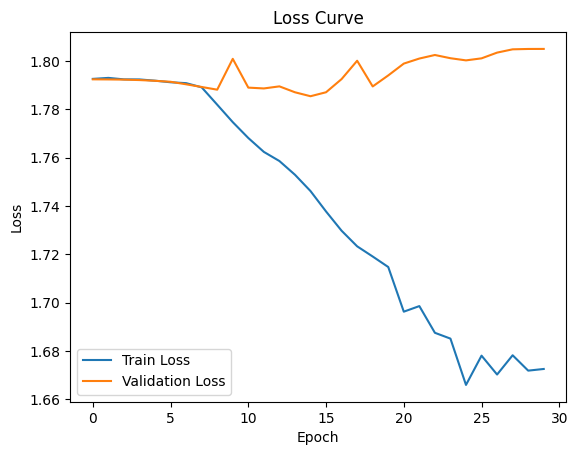

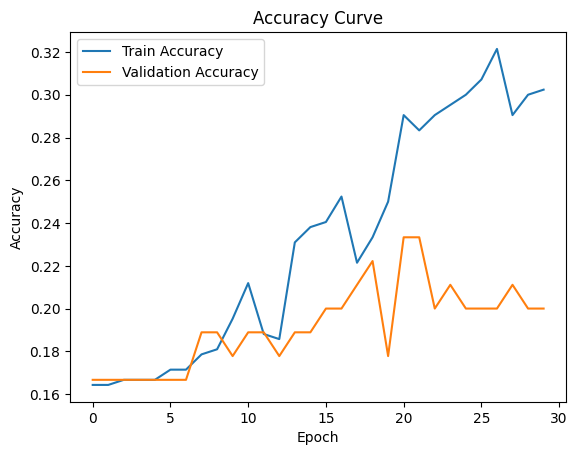

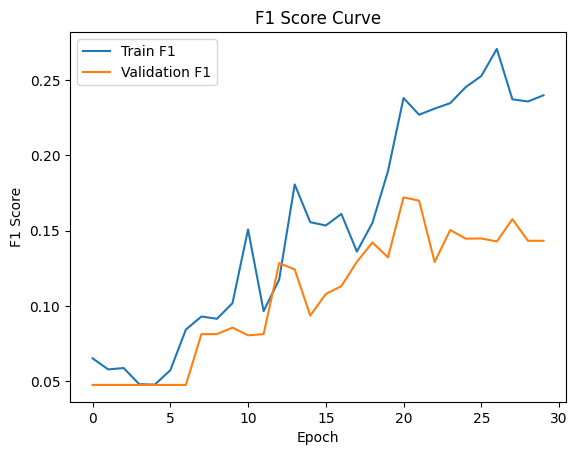

,Epoch,Train Loss,Valid Loss,Train Acc,Valid Acc,Train F1,Valid F1
0,1,1.7926,1.7924,0.1643,0.1667,0.0653,0.0476
1,2,1.7930,1.7924,0.1643,0.1667,0.0579,0.0476
2,3,1.7924,1.7923,0.1667,0.1667,0.0588,0.0476
3,4,1.7924,1.7921,0.1667,0.1667,0.0481,0.0476
4,5,1.7919,1.7918,0.1667,0.1667,0.0478,0.0476
5,6,1.7912,1.7914,0.1714,0.1667,0.0574,0.0476
6,7,1.7908,1.7904,0.1714,0.1667,0.0843,0.0476
7,8,1.7891,1.7893,0.1786,0.1889,0.0930,0.0813
8,9,1.7819,1.7881,0.1810,0.1889,0.0915,0.0813
9,10,1.7747,1.8009,0.1952,0.1778,0.1019,0.0857


In [38]:
plot_metrics(metrics, experiment_name)
create_metrics_table(metrics, experiment_name)